# Explorations in Japanese NLP

This Jupyter notebook explores various methods for processing Japanese text. We begin by examining word embeddings and their properties. After considering word segmentation, we discuss document representation methods. After doing some exploratory data analysis (EDA) on a dataset to be used for sentiment analysis, we compare 2 simple methods for sentiment analysis: naive Bayes with a bag of words document representation, and an ordinal neural method leveraging word embeddings. Finally, we demonstrate the use of a local LLM. We were interested in methods which could be efficiently carried out using only a consumer CPU.

In [1]:
# Import modules

import numpy as np

import voyager

from sklearn.manifold import TSNE, MDS
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB

import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'
from matplotlib import patches as mpatches

import MeCab

import pandas as pd
pd.set_option('display.max_colwidth', None)

import seaborn as sns

from statistics import mode

import re

from torch import Tensor
from torch import unsqueeze
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch import no_grad

from skopt.space.space import Integer, Real
from skopt import gp_minimize

from llama_cpp import Llama

## Word embeddings

Word embeddings are high-dimensional vector representations of words in a language which geometrically respect the semantic properties of the words.

There are various methods for finding words embeddings for a given vocabulary. Some, like GloVe, Word2Vec, produce non-contextualised embeddings, which capture only the average meaning of a word, whereas e.g. BERT, ELMo are contextualised, and can capture polysemy. However, all methods generally assume the *distributional hypothesis*: that words that are used in similar contexts have similar meanings. This allows the embeddings to be learned statistically from a large corpus of text.

Here we use pre-trained Japanese [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) embeddings ([Learning Word Vectors for 157 Languages](https://arxiv.org/abs/1802.06893) (Grave et al.)), which are non-contextualised. Compared to other non-contextualised embeddings, fastText has the advantage of incorporating subword information, which is useful for languages with a rich morphology like Japanese (which is an agglutinative language).

In [2]:
# Load word embeddings into a dictionary

f = open('C:\\Users\\chris\\Documents\\J_sentiment\\cc.ja.300.vec', 'r', encoding = 'utf-8', newline = '\n', errors = 'ignore')
vocab_size, dimension = [int(x) for x in f.readline().split()]
word_embedding = {}
for line in f:
    values = line.split()
    word_embedding[values[0]] = np.array(values[1:], dtype = 'float32')

In [3]:
# Inspect vocab_size and dimension

print(vocab_size)
print(dimension)

2000000
300


To examine the semantic properties of word embeddings, we first look at some nearest neighbours.

Throughout this notebook, we measure the "distance" between word embeddings using the cosine distance, which is common for word embeddings.

Since we have a large number of words and a high dimensionality (300) we want to use an efficient nearest neighbour search algorithm. Here we use the [Voyager](https://github.com/spotify/voyager) implementation of the hierarchical navigable small world (HNSW) algorithm. The HSNW algorithm is a state of the art approximate nearest neighbour search algorithm. 

Creating the index below takes about about 15 minutes on the author's laptop, even with batch loading (since there are 2 million words), but then the querying is fast.

In [4]:
# Set up index for k-nearest neighbour search

word_index = voyager.Index(voyager.Space.Cosine, 300)

batch = []
for v in word_embedding.values():
    if len(batch) == 9999:
        batch.append(v)
        word_index.add_items(np.array(batch, dtype = 'float32'))
        batch.clear()
    else:
        batch.append(v)

In [5]:
# Define function for k-nearest neighbours of a word

def word_nearest_neighbours(word, k_value):
    r = word_index.query(word_embedding[word], k = k_value)[0]
    print([list(word_embedding.keys())[i] for i in r])

In [6]:
# Examine nearest neighbours

word_nearest_neighbours('犬', 10)
word_nearest_neighbours('友達', 10)
word_nearest_neighbours('速い', 10)
word_nearest_neighbours('輝く', 10)
word_nearest_neighbours('残念', 10)
word_nearest_neighbours('2012', 10)

['犬', '飼い犬', 'ワンコ', '飼い主', '愛犬', '猫', '子犬', '仔犬', '柴犬', 'ドーベルマン']
['マウコ', 'アイバカ', 'ワィワィ', 'ニノファン', 'オフカイ', 'ドリフレ', 'ワンコオフ', 'ココタニ', 'オヨバレ', 'ジョグノ']
['速い', '速く', '速かっ', '遅い', '早い', 'はやい', '速けれ', '速め', '早かっ', '速くっ']
['輝く', '光り輝く', '輝い', '輝き', '輝ける', '光り輝い', '光る', 'きらめく', '煌めく', '輝か']
['残念', 'ザンネン', 'がっかり', 'ざんねん', '返す返す', '悔しい', '心残り', '惜しい', 'ガッカリ', '惜しかっ']
['252012', '052012', '272011', '272013', '082012', '272010', '252011', '032012', '272012', '262012']


As seen, the nearest neighbours to a word have very similar meanings to it. Of course, the closest to a given word is itself.

Next, we perform some visualisation of word embeddings using dimensionality reduction techniques. We use 2 standard nonlinear dimensionality reduction methods: multidimensional scaling (MDS) and t-distributed stochastic neighbour embedding (t-SNE). We use the implementations in scikit-learn.

The idea of the visualisation is the following: the Japanese writing system uses *kanji* which themselves have semantic content. If we look at the words which contain a given *kanji*, we expect them to have similar meanings and hence be reasonably close in the embedding space.

In [7]:
# Define function returning list of words containing a given kanji

def words_containing(kanji):
    return [w for w in word_embedding.keys() if kanji in w]

In [8]:
# Create the lists for some kanji

moo = words_containing('猛')
too = words_containing('透')
see = words_containing('整')
bu = words_containing('武')

In [9]:
# Create matrix for visualisation and compute pairwise cosine distances

X_words = np.array([word_embedding[w] for w in moo + too + see + bu], dtype = 'float32')
distances = cosine_distances(X_words)

In [10]:
# Perform MDS

mds = MDS(max_iter = 800, dissimilarity = 'precomputed', random_state = 0)
X_words_transform_mds = mds.fit_transform(distances)

In [11]:
# Perform t-SNE

tsne = TSNE(n_components = 2, perplexity = 28, n_iter = 5000, random_state = 0, metric = 'precomputed')
X_words_transform_tsne = tsne.fit_transform(distances)

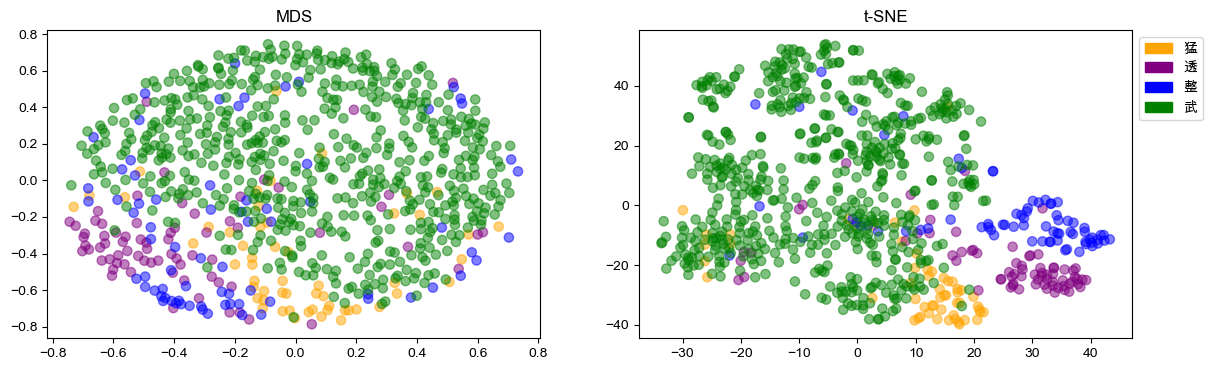

In [12]:
# Plot results

x_mds = X_words_transform_mds[:, 0]
y_mds = X_words_transform_mds[:, 1]

x_tsne = X_words_transform_tsne[:, 0]
y_tsne = X_words_transform_tsne[:, 1]

fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))

words_colours = (['orange'] * len(moo)) + (['purple'] * len(too)) + (['blue'] * len(see)) + (['green'] * len(bu))

ax1.scatter(x_mds, y_mds, color = words_colours, s = 45, alpha = 0.5)
ax1.set_title('MDS')

ax2.scatter(x_tsne, y_tsne, color = words_colours, s = 45, alpha = 0.5)
ax2.set_title('t-SNE')
patchlist = [mpatches.Patch(color = 'orange', label = '猛'), mpatches.Patch(color = 'purple', label = '透'), mpatches.Patch(color = 'blue', label = '整'), mpatches.Patch(color = 'green', label = '武')] 
ax2.legend(handles = patchlist, bbox_to_anchor = (1, 1), loc = 'upper left')

plt.show()

As expected, the embeddings show clear clustering according to the *kanji*.

Apart from providing synonym search, word embeddings have many practical applications. In this notebook, we will use word embeddings to create document embeddings, which in turn will be used to perform sentiment analysis.

## Document representation methods

As far as we are concerned in this notebook, a document is a portion of text in some natural language, and could be just a single sentence. In NLP, documents are the main type of data one is interested in, and as in other areas of machine learning, finding useful data representations is one of the key problems. Document representations have many applications, e.g. various kinds of text classification, information retrieval etc. Here we use them for sentiment analysis, a standard text classification problem.

There are two main classes of document representation method used in NLP to date:

* sparse, bag of words representations – here a document is represented by the integer counts of the words that occur in it. This can be expressed as a sparse, integer-valued vector of dimension the size of the vocabulary one is working with. Thus, the resulting representation usually has several thousand dimensions. Alternatively, this can be viewed as a multiset over the vocabulary, which ignores word order – hence the document is being represented as a 'bag' of words. Although such a representation may seem overly naive to be useful, such representations provide strong baselines for certain NLP tasks like spam classification etc. A variant of the simple integer count representation is the tf-idf representation.
* dense, real vector representations/ document embeddings – here a document is represented by a real-valued vector in a high-dimensional vector space. However, the dimensionality is usually in the hundreds rather than thousands. Similar to word embeddings, document embeddings are usually intended as a representation of the semantics of documents. There are many document embedding techiques – a brilliant overview is given by Shay Palachy [here](https://www.kdnuggets.com/2019/10/beyond-word-embedding-document-embedding.html). One of the simplest methods, which is nonetheless surprisingly effective, is, given pre-trained word embeddings, to sum or average the embeddings of the words in the document. Note that this therefore disregards syntax, word order etc. We will use this method here, for convenience, and to see how far it can go.

Since the Japanese writing system doesn't usually use spaces between words, to apply our document embedding methods to a document/sentence given as a single string, we first need to separate the words.

To do so, we use the widely used [MeCab](https://taku910.github.io/mecab/) word segmentation library (based on conditional random fields (CRFs)), and its Python wrapper [mecab-python3](https://pypi.org/project/mecab-python3/).

In [3]:
# Set up MeCab

wakachi = MeCab.Tagger('-Owakati')

def segment(text):
    return wakachi.parse(text).split()

In [14]:
# MeCab demonstrations with a variety of inputs

print(segment('この曲大好きなんだよなぁ')) 
print(segment('お忙しいところ恐縮ですが、ご都合の良い日はありますでしょうか')) 
print(segment('経済協力開発機構'))

['この', '曲', '大好き', 'な', 'ん', 'だ', 'よ', 'なぁ']
['お', '忙しい', 'ところ', '恐縮', 'です', 'が', '、', 'ご', '都合', 'の', '良い', '日', 'は', 'あり', 'ます', 'でしょう', 'か']
['経済', '協力', '開発', '機構']


As seen, MeCab effectively segments strings, even handling things like なぁ well. Long compounds like 経済協力開発機構 (OECD) are segmented into component words, which is appropriate for text analysis.

For the bag of words representation we will use the implementation of sklearn. We define our dense, document embedding function here – we choose averaging over summing to combine the word embeddings.

Note that we define the function to ignore words that don't have word embeddings – there are few such words.

In [4]:
# Define document embedding function
def document_embedding(text):
    intermediate = [x for x in segment(text) if x in word_embedding.keys()]
    vectors = [word_embedding[x] for x in intermediate]
    return (1/len(vectors)) * np.sum(vectors, axis = 0)

## Sentiment analysis

The basic task in sentiment analysis is to assign to a given sentence or short document a label indicating its sentiment/emotional polarity: how positive or negative its attitude is. Sentiment analysis has important applications in marketing and customer service etc.

Although sentiment analysis is often done in a binary form ($-1$ negative vs $1$ positive) here we are doing 3-way sentiment analysis ($-1$ negative vs $0$ neutral vs $1$ positive). We regard this as more realistic, but it is also more challenging than simple binary sentiment classification. Significantly, 3-way sentiment analysis is not merely a classification problem anymore (although it is often treated as such), since there is a natural non-trivial order on the set of labels: $-1 < 0 < 1$ and we might want to e.g. regard a positive document being misclassified as $-1$ as a worse mistake than being misclassified as $0$. Hence we might naturally view 3-way sentiment analysis as an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) problem, a situation which has characteristics of both classification and regression problems.

We compare two simple methods using both kinds of document representation. First, naive Bayes with simple bag of words document representation. Then, using the simple document embedding function defined above, we tranform the problem of 3-way sentiment analysis into a pure ordinal regression problem, which we approach using a relatively shallow neural network.

Other than these two methods, other commonly used and generally effective methods for text classification are a SVM classifier with either a simple count or tf-idf document representation, or fine-tuning a BERT model. Also, recurrent neural network approaches like LSTMs are also quite effective.

### Dataset

The dataset we use for sentiment analysis is the objective sentiment information from version 2 of [WRIME](https://github.com/ids-cv/wrime/tree/master). Posts on a social media site were annotated by 3 annotators with sentiment polarity.

The dataset actually gives 5-way sentiment scores ($-2$ very negative vs $-1$ negative vs $0$ neutral vs $1$ positive vs $2$ very positive). After exploring the dataset, we decide to reduce these 5 categories to just 3, as explained below.

The dataset contains other interesting information as well as sentiment scores: subjective sentiment scores and ratings for emotional categories (joy, sadness, anticipation, surprise, anger, fear, disgust, and trust). However, we do not use that information here.

In [5]:
# Load the whole dataset
full_df = pd.read_csv('C:\\Users\\chris\\Documents\\J_sentiment\\wrime-ver2.tsv', sep = '\t')

In [6]:
# Extract columns
df = full_df[['Sentence', 'Train/Dev/Test', 'Reader1_Sentiment', 'Reader2_Sentiment', 'Reader3_Sentiment']].copy()
display(df)

,Sentence,Train/Dev/Test,Reader1_Sentiment,Reader2_Sentiment,Reader3_Sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,train,-2,-1,-1
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も悪くない。,train,2,1,1
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,train,0,0,1
3,眠い、眠れない。,train,-1,-1,-1
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,train,-1,0,0
...,...,...,...,...,...
34995,真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。\n\n環境変えるのって効果絶大。,dev,1,1,1
34996,ぐっどこんでぃしょん。\n心も頭もクリア。\n秋分の日のおかげかな？\n人と自然としっとり過ごしたい気分。,dev,1,1,2
34997,朝から免許の更新へ。\n90分で終わり、出口へ向かうと献血の呼びかけが。\nみんな通り過ぎていく。\n献血を申し出ると丁寧に対応してくれて、スムーズに終わった。\n帰り際、若い係員さんが真っ直ぐこちらを見て「ありがとうございましたー！」と。\n今日はサウナに入れないけど、清々しい気持ちになった。,dev,1,1,2
34998,夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始…\n\nぼんやり秋の夜長を楽しみたい。\n土曜だし！,dev,1,1,2


As we can see, the sentences are reasonably short, and written in a loose social media style.

Let's compare the sentiment rating biases of each reader.

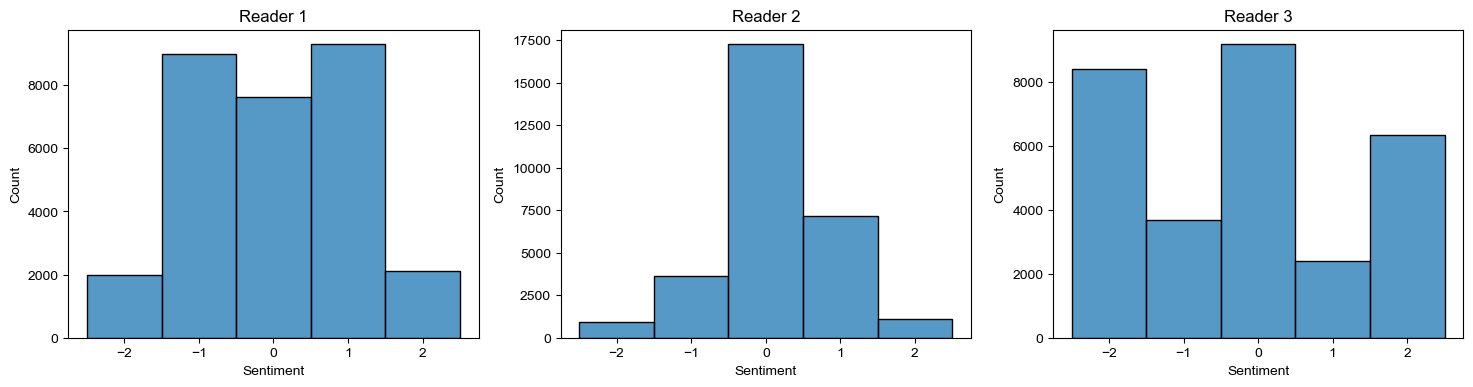

In [7]:
# Compare biases of each rater on training set

df_train = df[df['Train/Dev/Test'] == 'train']

fig, [ax1, ax2, ax3] = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 4))

sns.histplot(df_train, x = 'Reader1_Sentiment', discrete = True, ax = ax1)
ax1.set_title('Reader 1')
ax1.set_xlabel('Sentiment')

sns.histplot(df_train, x = 'Reader2_Sentiment', discrete = True, ax = ax2)
ax2.set_title('Reader 2')
ax2.set_xlabel('Sentiment')

sns.histplot(df_train, x = 'Reader3_Sentiment', discrete = True, ax = ax3)
ax3.set_title('Reader 3')
ax3.set_xlabel('Sentiment')

plt.show()

As we can see from these histograms, each of the readers have a different distribution of ratings: reader 1 is reasonably balanced, but doesn't frequently give $-2$ or $2$, reader 2 rates most things as neutral, and reader 3 tends to give more extreme ratings. Although widely used, there are some general psychological issues with such discrete rating scales, and in this case probably many people would have difficulty distinguishing between e.g. $-1$ and $-2$ etc.

So as not to have to worry about variance due to different reader biases, we take the sentiment score to be the mode of the scores of the readers. We also change $-2$ to $-1$ and $2$ to $1$ which also reduces the imbalance of the classes.

We then separate the data into training, validation, and test sets.

In [8]:
# Replace -2, 2 with -1, 1 respectively
df.replace(to_replace = -2, value = -1, inplace = True)
df.replace(to_replace = 2, value = 1, inplace = True)

# Form new column based on votes of ratings by the readers, and extract just that as the rating
df['Sentiment'] = df.apply(lambda x: mode([x['Reader1_Sentiment'], x['Reader2_Sentiment'], x['Reader3_Sentiment']]), axis=1)
chosen = df[['Sentence', 'Train/Dev/Test', 'Sentiment']].copy()

# Drop sentences that don't have document embeddings
for i in chosen.index:
    if len([x for x in segment(chosen.loc[i, 'Sentence']) if x in word_embedding.keys()]) == 0:
        chosen.drop(i, inplace = True)
        
chosen.reset_index(drop = True, inplace = True)

# Separate into training, validation, test
temp_train = chosen[chosen['Train/Dev/Test'] == 'train']
train = temp_train[['Sentence', 'Sentiment']].to_dict('list')

temp_validate = chosen[chosen['Train/Dev/Test'] == 'dev']
validate = temp_validate[['Sentence', 'Sentiment']].to_dict('list')

temp_test = chosen[chosen['Train/Dev/Test'] == 'test']
test = temp_test[['Sentence', 'Sentiment']].to_dict('list')

In [20]:
# Inspect size of sets

print(len(train['Sentence']))
print(len(validate['Sentence']))
print(len(test['Sentence']))

29940
2498
2498


In [9]:
# Inspect class distribution 

print(test['Sentiment'].count(-1))
print(test['Sentiment'].count(0))
print(test['Sentiment'].count(1))

681
725
1092


For evaluating the sentiment analysis models on the dataset, we use a mixture of standard classification and regression metrics. Depending on the final application, one metric score may be more or less important than one of the others. 

In [21]:
# Define evaluation function

def ordinal_evaluation(y_true, y_pred):
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap = 'Blues')
    plt.show()
    
    print('The accuracy is:', round(accuracy_score(y_true, y_pred), 3))
    
    print('The F1 score is:', round(f1_score(y_true, y_pred, average = 'macro'), 3))
    
    print('The MAE is:', round(mean_absolute_error(y_true, y_pred), 3))

### Naive Bayes

Naive Bayes is a simple probabilistic classifier method that assumes the conditional independence of the words in a document/sentence. It essentially assumes the bag of words document representation method.

Here we implement a naive Bayes classifier using the implementation in sklearn. For the count bag of words document representation we also use the sklearn implementation, `CountVectorizer`.

In [22]:
# Define function that preprocess and tokenises text

def tokenizer(text):
    
    # Replace alphabetic strings with 'ALPHA'
    text = re.sub(r'[a-zA-Z]+', 'ALPHA', text)
    
    # Replace number strings with 'NUMBER'
    text = re.sub(r'\d+', 'NUMBER', text)
    
    return segment(text)

In [23]:
# Fit vectoriser on training data, using MeCab tokeniser

cv = CountVectorizer(lowercase = False, tokenizer = tokenizer, min_df = 0.0005)
cv.fit(train['Sentence'])

CountVectorizer(lowercase=False, min_df=0.0005,
                tokenizer=<function tokenizer at 0x000001CCD156BCA0>)

In [24]:
# Inspect vocabulary size

len(cv.get_feature_names_out())

3421

In [25]:
# Define wrapper function for the vectorisation of arbitrary input text

def cvf(text):
    return cv.transform([text]).toarray()[0]

Naive Bayes takes a smoothing hyperparameter $\alpha$ which we optimise here using a simple grid search.

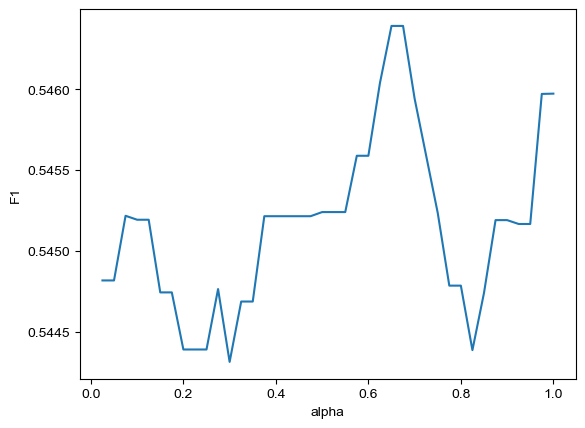

In [26]:
# Hyperparameter optimisation of the model (simple grid search)

alpha_values = list(np.linspace(0.025, 1, 40))

f1_scores = []

for a in alpha_values:
    nb = ComplementNB(alpha = a)
    nb.fit([cvf(s) for s in train['Sentence']], train['Sentiment'])
    k = f1_score(validate['Sentiment'], nb.predict([cvf(s) for s in validate['Sentence']]), average = 'macro')
    f1_scores.append(k)

plt.plot(np.array(alpha_values), np.array(f1_scores))
plt.xlabel('alpha')
plt.ylabel('F1')

plt.show()

In [27]:
# Fit model with chosen hyperparameter

nb = ComplementNB(alpha = alpha_values[np.argmax(f1_scores)])
nb.fit([cvf(s) for s in train['Sentence']], train['Sentiment'])

ComplementNB(alpha=0.65)

In [28]:
# Define wrapper function for inference

def nb_classifier(text):
    return nb.predict([cvf(text)])[0]

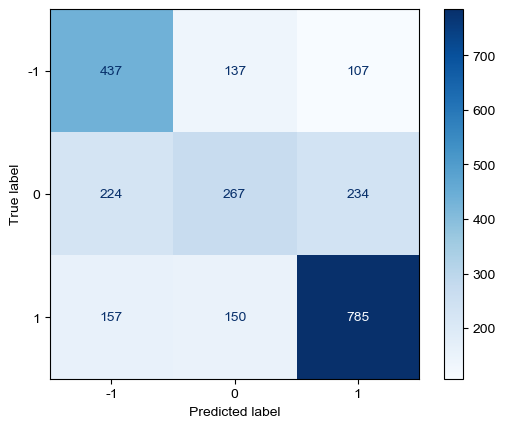

The accuracy is: 0.596
The F1 score is: 0.569
The MAE is: 0.51


In [29]:
# Evaluation on test set

ordinal_evaluation(test['Sentiment'], [nb_classifier(s) for s in test['Sentence']])

As seen, the performance isn't brilliant, but it is in line with what one would expect from naive Bayes from the literature and for 3-way classification. It is also important to note that the performance is significantly better than the trivial classifier which always predicts the majority class $1$, which would have accuracy of $0.437$.

### Ordinal deep averaging network

Here a sentence is mapped to its bag of embeddings document embedding, and then rated using a neural network.

The idea is a variant of the classical 'deep averaging network' (DAN), introduced in the paper [Deep Unordered Composition Rivals Syntactic Methods for Text Classification](https://aclanthology.org/P15-1162/) (Iyyer et al.), but we consider 3-way sentiment analysis and an ordinal approach instead, whereas the paper considers a classification setting. 

There are various approaches to ordinal regression. One can directly approach it via generalised linear models, but here we use the simplest approach: treat the labels $-1, 0, 1$ as real numbers and train a regression model. Then predictions are made by rounding the output of the model to the nearest label.

We make the following choices for the architecture and training of the neural network:

* We fix the number of hidden layers to 2, both with the same dimension $d$ for simplicity, which is a hyperparameter. Thus the dimensions of the layers of the network are $300, d, d, 1$.
* We use ReLU activation functions.
* We use MAE as the loss function. 
* The network weights are initialised using Kaiming/He initialisation, which works well with ReLU activation functions.
* The network is trained using stochastic gradient descent (SDG) with batch size $32$, a learning rate schedule with decay $g$, and early stopping. We also use momentum with value $0.9$.
* we also use gradient clipping – this is not required for reasonable choices of hyperparameters, but was included to carry out hyperparameter optimisation with a wide range of hyperparameters.

We use PyTorch to implement the network.

In [30]:
# Prepare training data

train_X = Tensor(np.array([document_embedding(s) for s in train['Sentence']], dtype = 'float32'))
train_y = unsqueeze(Tensor(np.array(train['Sentiment'], dtype = 'float32')), 1)

In [31]:
# Prepare validation data

validate_X = Tensor(np.array([document_embedding(s) for s in validate['Sentence']], dtype = 'float32'))
validate_y = unsqueeze(Tensor(np.array(validate['Sentiment'], dtype = 'float32')), 1)

In [32]:
# Define weight initialisation function

def weight_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        layer.bias.data.fill_(0.0)

In [33]:
# Define early stopper

class EarlyStopper:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [34]:
# Define hyperparameter optimisation objective function
# The function takes a tuple of hyperparameters, defines and trains the model with those hyperparameters, and returns the MSE on the validation set

def hyp_obj(d, initial_lr, g):
    
    model = nn.Sequential(nn.Linear(300, d), nn.ReLU(), nn.Linear(d, d), nn.ReLU(), nn.Linear(d, 1))
    model.apply(weight_init)
    
    loss_function = nn.L1Loss()
    optimiser = SGD(model.parameters(), lr = initial_lr, momentum = 0.9)
    scheduler = StepLR(optimiser, step_size = 10, gamma = g)
    
    train_dataset = TensorDataset(train_X, train_y)
    data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)
    
    early_stopper = EarlyStopper(patience = 15)
    
    for epoch in range(1, 150):
        for i, batch in enumerate(data_loader):
            batch_X, batch_y = batch
            optimiser.zero_grad()
            loss = loss_function(model(batch_X), batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimiser.step()
        scheduler.step()
        with no_grad():
            val_loss = loss_function(model(validate_X), validate_y).item()
        if early_stopper.early_stop(val_loss):
            break
            
    return val_loss 

For hyperparameter optimisation, we use the implementation of Bayesian optimisation in [scikit-optimize](https://scikit-optimize.github.io/stable/).

Bayesian optimisation is appropriate here considering the mixed nature of the hyperparameters (some are discrete, some continuous), that evaluating the hyperparameter objective function is computationally expensive and noisy etc.

In [35]:
# Hyperparameter optimisation

def f(x):
    return hyp_obj(*x)

dimensions_list = [Integer(50, 150, dtype = int), Real(0.1, 0.8, dtype = float), Real(0.1, 0.7, dtype = float)]
res = gp_minimize(f, dimensions_list, n_calls = 15, n_initial_points = 5, random_state = 0)
print('The optimal hyperparameters are:', res.x)
print('The value of hyp_obj at these hyperparameters is:', res.fun)

The optimal hyperparameters are: [135, 0.5364945877501808, 0.3306290243756199]
The value of hyp_obj at these hyperparameters is: 0.4856691062450409


Below we train the model (again from scratch) with the optimal hyperparameters but this time plotting training and validation loss curves.

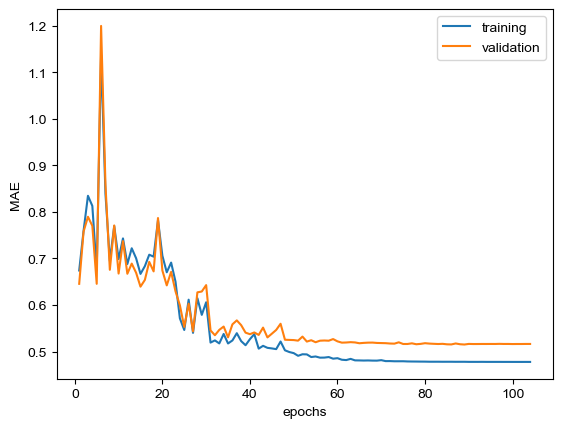

In [36]:
# Train model with optimal hyperparameters + plot training vs validation curves

d = res.x[0]
initial_lr = res.x[1]
g = res.x[2]

epochs = []
training_losses = []
validation_losses = []

model = nn.Sequential(nn.Linear(300, d), nn.ReLU(), nn.Linear(d, d), nn.ReLU(), nn.Linear(d, 1))
model.apply(weight_init)
    
loss_function = nn.L1Loss()
optimiser = SGD(model.parameters(), lr = initial_lr, momentum = 0.9)
scheduler = StepLR(optimiser, step_size = 10, gamma = g)
    
train_dataset = TensorDataset(train_X, train_y)
data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)
    
early_stopper = EarlyStopper(patience = 15)
    
for epoch in range(1, 150):
    epochs.append(epoch)
    for i, batch in enumerate(data_loader):
        batch_X, batch_y = batch
        optimiser.zero_grad()
        loss = loss_function(model(batch_X), batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimiser.step()
    with no_grad():
        tr_loss = loss_function(model(train_X), train_y).item()
        training_losses.append(tr_loss)
    scheduler.step()
    with no_grad():
        val_loss = loss_function(model(validate_X), validate_y).item()
        validation_losses.append(val_loss)
    if early_stopper.early_stop(val_loss):
        break
        
plt.plot(np.array(epochs), np.array(training_losses), label = 'training')
plt.plot(np.array(epochs), np.array(validation_losses), label = 'validation')

plt.xlabel('epochs')
plt.ylabel('MAE')
plt.legend() 

plt.show()

From the plot we see that there is some overfitting on the training set, though the validation loss doesn't really get much worse for some time.

We define the function for inference by incorporating rounding with a hyperparameter $U$, which we optimise separately.

In [37]:
# Define auxiliary rounding function

def rnd(y, U):
    if abs(y) <= U:
        return 0
    elif y > U:
        return 1
    else:
        return -1 

In [38]:
# Define function for inference

def ordinal_neural(sentence, U):
    x = Tensor(document_embedding(sentence))
    return rnd(model(x).item(), U)

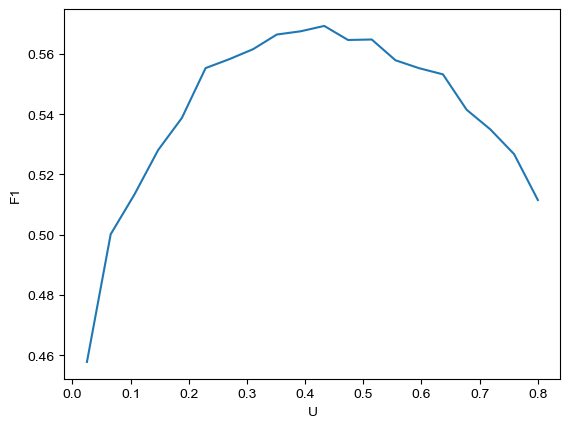

In [39]:
# Tuning of U

U_values = list(np.linspace(0.025, 0.8, 20))

scores = []

for u in U_values:
    k = f1_score(validate['Sentiment'], [ordinal_neural(s, u) for s in validate['Sentence']], average = 'macro')
    scores.append(k)
    
plt.plot(np.array(U_values), np.array(scores))
plt.xlabel('U')
plt.ylabel('F1')

plt.show()

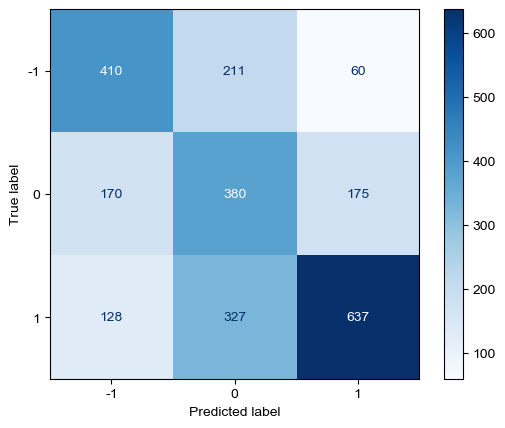

The accuracy is: 0.571
The F1 score is: 0.567
The MAE is: 0.504


In [40]:
# Evaluation on test set

ordinal_evaluation(test['Sentiment'], [ordinal_neural(s, U_values[np.argmax(scores)]) for s in test['Sentence']])

Compared to the naive Bayes model, this has a slightly lower accuracy and F1, but the MAE is lower.

The confusion matrix is also 'local' (unlike the naive Bayes model) due to the ordinal approach providing a stronger inductive bias, making misclassifications less problematic in many applications. $0$ is also finally being classified correctly most of the time. Overall such a sentiment analysis model would be good enough for applications where a certain amount of local error is tolerated.

It is worth noting here that trying to bootstrap static word embeddings for text classification, while quite successful for tasks such as document similarity, document entailment etc, tends to perform less well for sentiment analysis due to the fact that antonyms (which often have opposite sentiments) are often close in the word embedding space. 

### Discussion

Overall, both models are reasonable sentiment analysis models considering that they don't take syntax etc. into account, and the inherent difficulties of the task (3-way, the neutral class can be ambigious with even humans not agreeing much of the time etc.) and dataset. We emphasise that our intention here was not to implement models with the best possible performance, but instead to test the performance of some classical methods. It would be worth testing the performance of a fine-tuned BERT model on this same dataset for comparison.

## Local LLM

We finish by demonstrating the use of a local Japanese large language model (LLM) for various NLP tasks using only a consumer CPU. This is possible thanks to quantisation of the weights of the model, the [llama.cpp](https://github.com/ggerganov/llama.cpp) library, and its Python bindings [llama-cpp-python](https://github.com/abetlen/llama-cpp-python).

Here we use ELYZA's Japanese 7B fast [model](https://huggingface.co/elyza/ELYZA-japanese-Llama-2-7b-fast-instruct) based on Llama 2, with 3-bit [quantisation](https://huggingface.co/mmnga/ELYZA-japanese-Llama-2-7b-fast-instruct-gguf) by mmnga. Like most LLMs, Llama is a decoder-only transformer model. 

In [41]:
# Load LLM 

llm = Llama(model_path = 'C:\\Users\\chris\\Documents\\llms\\ELYZA-japanese-Llama-2-7b-fast-instruct-q3_K_M.gguf', n_ctx = 1000, n_batch = 150, n_threads = 3, verbose = False)

Each LLM is trained with a certain prompt format, hence it is important to use the same one when querying the language model. Here the prompt format is as follows:

In [42]:
# Define function to format prompt according to the required prompt template

def format_prompt(prompt):
    return f'[INST] <<SYS>>\nあなたは誠実で優秀な日本人のアシスタントです。\n<</SYS>>\n\n{prompt} [/INST]'

In [43]:
# Define wrapper function for inference

def response(prompt, m):
    return llm(format_prompt(prompt), max_tokens = m, temperature = 0.5)['choices'][0]['text'].strip()

In [44]:
# Demonstration

print(response('忍耐の大切さについての短い作文を書いてください。', 200))

承知しました。以下は、忍耐の大切さを示す例となる短い物語です。

ある日、白雪姫は魔法使いに魔法をかけられました。その魔法は、何事もなくさずにはいけないというものです。白雪姫は、花が咲くまで待つしかないと考えました。しかし、ずっとじっとしているのは苦痛で、腹を立てることも、歩くことさえできなくなってしまいました。

ある日、白雪姫は森の動物に助けられました。彼女は魔法が解けるのをじっと待っていました。すると、遠くからピッタリと音がし、大きな木の葉が落ちてきました。その下には、可愛い赤ちゃんがいました。動物たちは喜んで、白雪姫に乳をあげました。

それからは、毎日あやふやにして乳をすくいます。


One can also stream the result:

In [45]:
# Define function for streaming the response

def stream_response(prompt, m):
    for i in llm(format_prompt(prompt), max_tokens = m, temperature = 0.5, stream = True):
        print(i['choices'][0]['text'], end = '', flush = True)

In [46]:
# Demonstration

stream_response('忍耐の大切さについての短い作文を書いてください。', 200)

  忍耐とは、困難や苦難に立ちはだかったり、我慢したりする心の強さのことを指します。

最近の子供たちは、物事がスムーズに行かず、すぐにイライラしたり、投げやりな気持ちになることが多いため、忍耐力が低下していると言われています。

しかし、本当に大切なことは、困難や苦難に立ちはだかったり、我慢することができると言ったわけではなく、それらを乗り越えて成し遂げる力である「忍耐」であると言えるでしょう。

だからこそ、子供の頃から忍耐力を養う必要があるのです。

The quality of the output is quite high, and the model follows instructions well, also considering the amount of quantisation. The speed of generation is a bit slow (approximately 6 tokens per second), but considering that only a consumer CPU is being used and that the size of the model is 7B parameters, it is relatively impressive. The speed would be fine for chat applications, when the user needs to read the text at their own reading speed. However, for applications which require low latency, more computing power would probably be required.

One can do sentiment analysis with LLMs:

In [47]:
# Define wrapper function for sentiment analysis

def classify_sentiment(sentence):
    return response(f'次の文章の感情極性を分類してください。-1（ネガティブ）か0（ニュートラル）か1（ポジティブ）か、単一の数字で答えてください。\n\n文章：「{sentence}」', 100)

In [48]:
# Demonstration

print(classify_sentiment('うれしい～'))
print(classify_sentiment('そんな男嫌いだ'))
print(classify_sentiment('まあまあだったかな'))

承知しました。与えられた文章の感情極性を分類します。

-1 (ネガティブ)

なぜなら、「うれしい」という感情はポジティブな感情であり、ネガティブな感情とは対照的なものです。
-1
承知しました。文章の感情極性を分類します。

-1 (ネガティブ) ではないと考えられるのは、「まあまあだったかな」という表現から、ある程度良い印象を受けるからです。

したがって、感情極度は1 (ポジティブ) です。


Although there is a bit of variability in the quality of the response (the responses are stochastic) this more or less works, and the LLM gives some "explanation" for its ratings. However, it is very slow and computationally intensive compared to the methods discussed above if only a rating is desired, at least on a CPU. Hence, similarly to as mentioned above, it is probably not most suitable for high volume applications, e.g. in business. However, if fine-tuned to output just a single number, this approach might be effective even for such applications.

LLMs are effective for text summarisation:

In [49]:
# Define wrapper function for text summarisation

def summarise(text):
    return response(f'次の文章を要約してください：「{text}」', 200)

In [50]:
# Demonstration

print(summarise('''4月18日にテレ朝newsで、Googleマップの悪質な口コミで医師集団がGoogleを提訴したことが報道されました。

原告団によりますと、不要な抗生剤の要求を断った際、悪い口コミを書き込まれたとことです。抗生物質耐性という問題を防ぐために、そう断るのは妥当であり、保険診療として処方してはいけないことだそうです。投稿者はその理由を知らなかったかもしれませんが、そうした悪い口コミは不当です。

守秘義務のゆえに、反論が難しいということです。虚偽の悪評は様々な産業に害を及ぼします。しかし、守秘義務はヘルスケア領域の特徴であり、この件の核心です。

誹謗中傷もありました。ある口コミが横浜市の歯科医院のサービスを「ゴミ未満」と呼びました。全般的に、プラットフォーマーはアルゴリズムを使い、中傷やスパムを検出したり削除したりします。Googleマップもそうです。そういう誹謗中傷が放置されたことに疑問があったようです。

原告団は営業権を侵害されたと主張しています。

提訴の結果がどうであれ、様々な問題が提起されています。企業におけるビッグ・テックの影響をどの程度まで許容すべきなのでしょうか。または、私たちの生活における影響。

最近、プラットフォームの弊害に対して責任を負わせる動向が加速し、 世界中で多くの裁判が行われています。
'''))

与えられた文章を要約いたします。

原告団は、Googleマップに不当な口コミを書かれているので代理人通報したところ、Google側から連絡が来て問題はないと言われたが、解決せず提訴されたという内容の話でした。


Which as seen, is quite reasonable, though sometimes the LLM copies large sections of the original text exactly.

Finally, one interesting problem/ type of hallucination we noticed was that the language model has trouble correctly giving the readings of *kanji* words, though quite possibly this isn't a problem with larger models:

In [51]:
# Illustration

print(response('我慢の読み方は何ですか。', 50))

「我慢」の読み方は、「がいひん」と読まれます。


Which is wrong, though similar/close to the correct reading がまん.